## Задание 6

### Визуализировать порождение сэмплов из RBM на выборке MNIST (Gibbs sampling):

$x_0$ - из выборки  
$h_0 \sim p(h_0|x_0)$  
$x_1 \sim p(x_1|h_0) ...$  
$x_k \sim p(x_k|h_{k-1})$  
показать, как меняются сэмплы в зависимости от шага k (можно анимированным графиком).
#### Гребенькова Ольга Сергеевна, М05-104

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.axis('off')
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [3]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=20,
                 n_class=10):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
        self.clf = nn.Linear(n_hin, n_class)
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v, is_clf=False):

        if is_clf == False:
            pre_h1,h1 = self.v_to_h(v)
            saved_images = []
            h_ = h1
            for _ in range(self.k):
                pre_v_,v_ = self.h_to_v(h_)
                pre_h_,h_ = self.v_to_h(v_)
                saved_images.append(v_)
            return v,v_, saved_images
        else:
            v_ = v
            for _ in range(self.k - 1):
                pre_h_,h_ = self.v_to_h(v_)
                pre_v_,v_ = self.h_to_v(h_)
                
            pre_h_,h_ = self.v_to_h(v_)
            
            return self.clf(pre_h_) 

    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

### Обучим модель RBM для 10 шагов и будем сохранять картинки на каждом шагу.

In [5]:
rbm = RBM(k=5)

In [6]:
train_op = optim.SGD(rbm.parameters(),0.1)
all_images = []
for epoch in tqdm(range(5)):
    loss_ = []
    for i, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1, saved_images = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        if i == 10:
            all_images.append(saved_images)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print(np.mean(loss_))

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-4.489847179160698
-5.7296350963080105
-3.6226467628723014
-2.2878180790557536
-1.4992108700880364


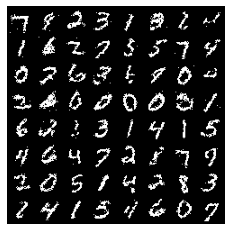

In [8]:
for n, i in enumerate(all_images):
    for k, j in enumerate(i):
        show_adn_save(f"{n}-{k}",make_grid(j.view(64,1,28,28).data))

In [13]:
import imageio
filenames = []
#for n in range(5):
for k in range(5):
    filenames.append(f'{1}-{k}.png')
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('sample_data/2Anim.gif', images)

## Результат для 5 шагов на одном и том же батче в течении 5 эпох
![SegmentLocal](Grebenkova_gif1.gif "segment")

## 5 шагов на одной итерации для 1 и 3 эпохи
![SegmentLocal](Grebenkova_gif2.gif "segment")
![SegmentLocal](Grebenkova_gif3.gif "segment")